# Section 1, Task 3: OLAP Queries and Analysis
## Online Analytical Processing for Retail Data Warehouse
*Objective:* Perform OLAP operations and analyze results  
*Marks:* 15

In [17]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("Libraries imported successfully!")

Libraries imported successfully!


## Connect to Data Warehouse
Connect to the SQLite database created in Task 2

In [18]:
# Connect to database
db_path = 'retail_dw.db'
conn = sqlite3.connect(db_path)

# Verify connection
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)
print("Connected to retail_dw.db\n")
print("Available tables:")
for table in tables['name']:
    count = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table}", conn)['count'][0]
    print(f"  - {table}: {count:,} rows")

Connected to retail_dw.db

Available tables:
  - CustomerDim: 98 rows
  - ProductDim: 447 rows
  - SalesFact: 447 rows
  - TimeDim: 259 rows
  - sqlite_sequence: 0 rows


## OLAP Query 1: Roll-up Operation
Aggregate data from lower to higher level - Total sales by country and quarter

In [ ]:
# ROLL-UP: Total sales by country and Quarter
rollup_query = """
SELECT 
    c.Country,
    t.Year,
    t.Quarter,
    SUM(s.TotalSales) as TotalSales,
    COUNT(DISTINCT s.InvoiceNo) as num_transactions,
    AVG(s.TotalSales) as avg_transaction_value,
    COUNT(DISTINCT s.CustomerId) as unique_customers
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerId = c.CustomerId
JOIN TimeDim t ON s.TimeId = t.TimeId
GROUP BY c.Country, t.Year, t.Quarter
ORDER BY c.Country, t.Year, t.Quarter
"""

rollup_result = pd.read_sql_query(rollup_query, conn)
print("ROLL-UP QUERY RESULTS: Sales by Country and Quarter")
print("="*60)
print(rollup_result.head(10))
print(f"\nTotal rows returned: {len(rollup_result)}")

ROLL-UP QUERY RESULTS: Sales by Country and Quarter
     Country  Year  Quarter  TotalSales  num_transactions  \
0  Australia  2024        3     6549.06                 2   
1  Australia  2024        4     7712.76                 6   
2  Australia  2025        1     6932.99                 8   
3  Australia  2025        2    25075.03                11   
4  Australia  2025        3     3672.11                 2   
5     Canada  2024        3    10922.95                 5   
6     Canada  2024        4    20131.34                14   
7     Canada  2025        1    11775.75                 7   
8     Canada  2025        2     5730.11                 9   
9     Canada  2025        3     4668.04                 5   

   avg_transaction_value  unique_customers  
0            3274.530000                 2  
1            1285.460000                 4  
2             866.623750                 5  
3            2279.548182                 7  
4            1836.055000                 2  
5     

## OLAP Query 2: Drill-down Operation
Navigate from higher to lower level of detail - Monthly sales for USA

In [ ]:
# DRILL-DOWN: Sales details for USA by month
drilldown_query = """
SELECT 
    t.Year, t.month, t.MonthName,
    p.Category,
    SUM(s.TotalSales) as total_sales,
    SUM(s.quantity) as total_quantity,
    COUNT(DISTINCT s.CustomerId) as unique_customers
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerId = c.CustomerId
JOIN TimeDim t ON s.TimeId = t.TimeId
JOIN ProductDim p ON s.ProductId = p.ProductId
WHERE c.Country = 'USA'
GROUP BY t.Year, t.month, t.MonthName, p.Category
ORDER BY t.Year, t.month, total_sales DESC
"""

drilldown_result = pd.read_sql_query(drilldown_query, conn)
print("DRILL-DOWN QUERY RESULTS: USA Sales by Month and Category")
print("="*60)
print(drilldown_result.head(10))
print(f"\nTotal rows returned: {len(drilldown_result)}")

DRILL-DOWN QUERY RESULTS: USA Sales by Month and Category
   Year  Month  MonthName     Category  total_sales  total_quantity  \
0  2024      8     August  Electronics      3988.60              49   
1  2024      8     August        Books      1204.08              24   
2  2024      9  September         Home      1069.61              62   
3  2024      9  September        Books        44.32              16   
4  2024     10    October     Clothing      3982.41             126   
5  2024     10    October  Electronics      3181.66              48   
6  2024     10    October       Sports       363.66              22   
7  2024     10    October        Books       278.24              47   
8  2024     11   November       Sports      2994.24              48   
9  2024     11   November         Home      2590.28              44   

   unique_customers  
0                 1  
1                 1  
2                 2  
3                 1  
4                 3  
5                 2  
6     

## OLAP Query 3: Slice Operation
Select a specific subset - Electronics category only

In [ ]:
# SLICE: Total sales for Electronics Category
slice_query = """
SELECT 
    p.ProductId,
    c.Country,
    SUM(s.quantity) as total_quantity_sold,
    SUM(s.TotalSales) as total_revenue,
    AVG(s.UnitPrice) as avg_price,
    COUNT(DISTINCT s.CustomerId) as unique_customers
FROM SalesFact s
JOIN ProductDim p ON s.ProductId = p.ProductId
JOIN CustomerDim c ON s.CustomerId = c.CustomerId
WHERE p.Category = 'Electronics'
GROUP BY p.ProductId, c.Country
ORDER BY total_revenue DESC
LIMIT 20
"""

slice_result = pd.read_sql_query(slice_query, conn)
print("SLICE QUERY RESULTS: Electronics Category Sales")
print("="*60)
print(slice_result.head(10))
print(f"\nTotal rows returned: {len(slice_result)}")

SLICE QUERY RESULTS: Electronics Category Sales
   ProductID    Country  total_quantity_sold  total_revenue  avg_price  \
0        361      Spain                   50        4951.50      99.03   
1        250        USA                   49        3988.60      81.40   
2        116  Australia                   38        3780.24      99.48   
3         36        USA                   47        3430.53      72.99   
4        273      Spain                   45        3233.70      71.86   
5        205  Australia                   32        3169.28      99.04   
6        279  Australia                   42        3056.76      72.78   
7        447     Canada                   37        2911.16      78.68   
8         75     France                   35        2900.10      82.86   
9        283     Canada                   38        2792.24      73.48   

   unique_customers  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
5    

## Visualization 1: Sales by Country
Create bar chart and pie chart showing sales distribution

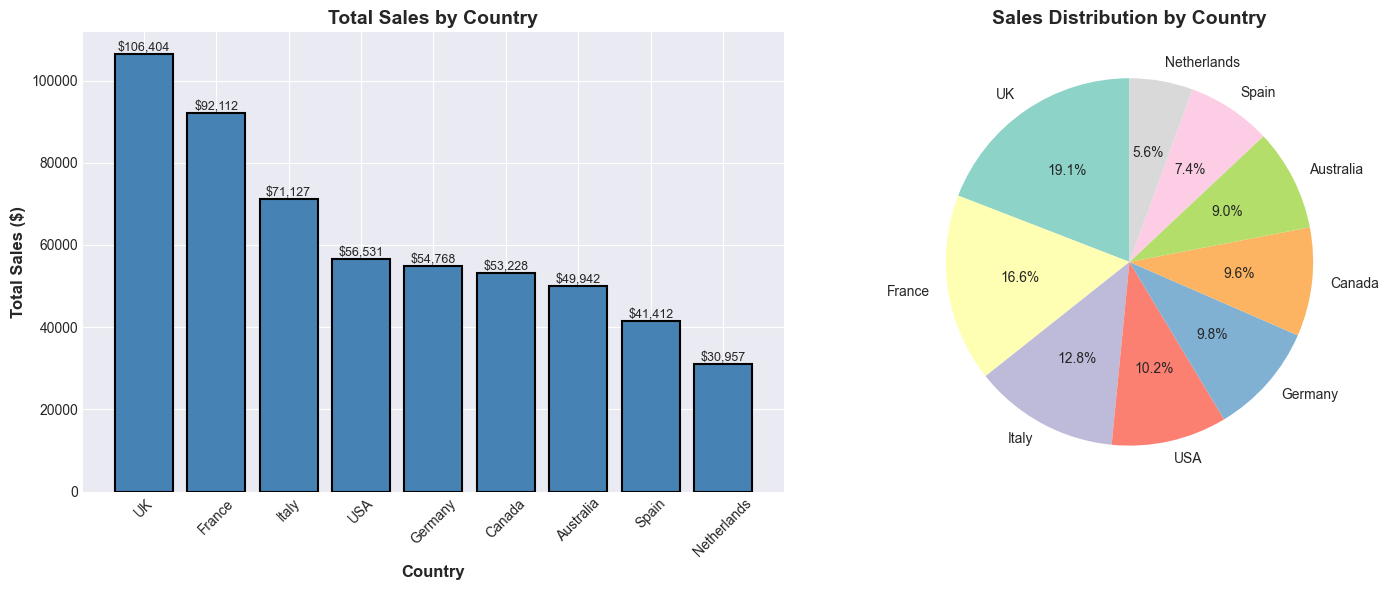


📊 Visualization saved as 'sales_by_country.png'


In [33]:
# Aggregate sales by country
country_sales_query = """
SELECT 
    c.Country,
    SUM(s.TotalSales) as TotalSales,
    COUNT(DISTINCT s.CustomerId) as unique_customers,
    COUNT(DISTINCT s.InvoiceNo) as transactions
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerId = c.CustomerId
GROUP BY c.Country
ORDER BY TotalSales DESC
"""

country_sales = pd.read_sql_query(country_sales_query, conn)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
bars = ax1.bar(country_sales['Country'], country_sales['TotalSales'], 
               color='steelblue', edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Country', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax1.set_title('Total Sales by Country', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

# Pie chart
colors = plt.cm.Set3(range(len(country_sales)))
ax2.pie(country_sales['TotalSales'], labels=country_sales['Country'],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sales Distribution by Country', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sales_by_country.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n📊 Visualization saved as 'sales_by_country.png'")

## Visualization 2: Quarterly Sales Trend
Create line chart showing quarterly trends

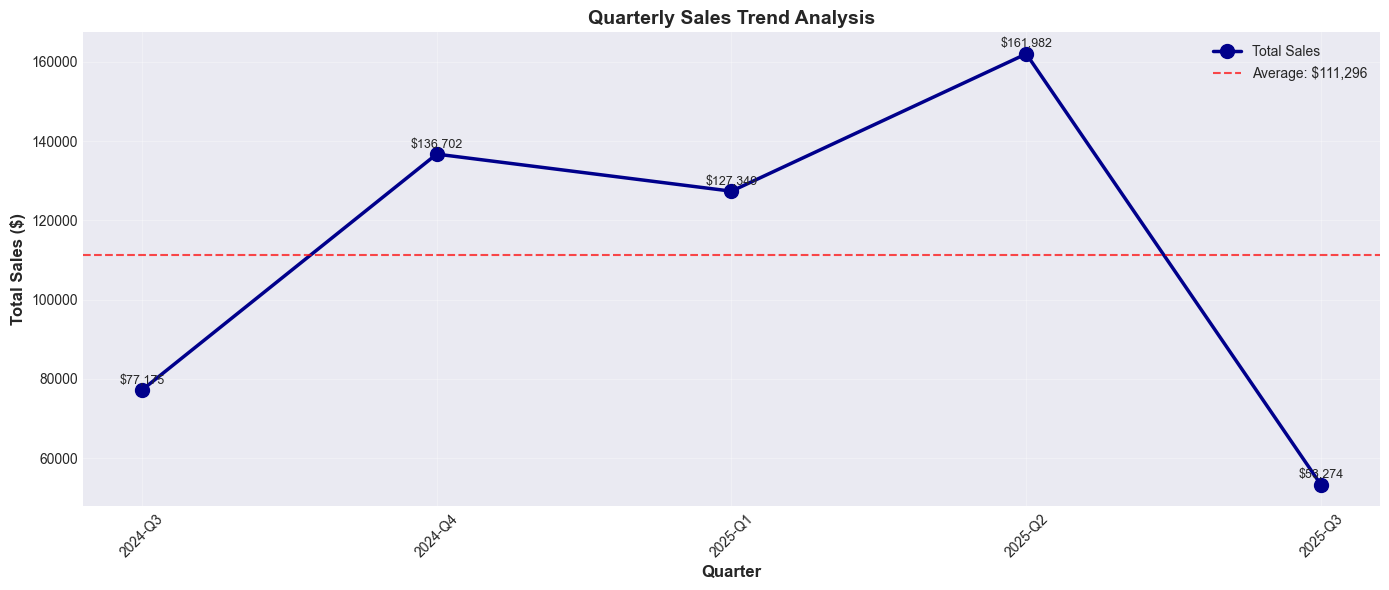


📊 Visualization saved as 'Quarterly_trend.png'


In [36]:
# Quarterly sales trend
Quarterly_query = """
SELECT 
    t.Year, t.Quarter,
    SUM(s.TotalSales) as TotalSales,
    COUNT(DISTINCT s.CustomerId) as unique_customers,
    AVG(s.TotalSales) as avg_transaction
FROM SalesFact s
JOIN TimeDim t ON s.TimeId = t.TimeId
GROUP BY t.Year, t.Quarter
ORDER BY t.Year, t.Quarter
"""

Quarterly_sales = pd.read_sql_query(Quarterly_query, conn)
Quarterly_sales['period'] = Quarterly_sales['Year'].astype(str) + '-Q' + Quarterly_sales['Quarter'].astype(str)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Line plot
ax.plot(Quarterly_sales['period'], Quarterly_sales['TotalSales'], 
        marker='o', linewidth=2.5, markersize=10, color='darkblue', label='Total Sales')

# Add average line
avg_sales = Quarterly_sales['TotalSales'].mean()
ax.axhline(y=avg_sales, color='red', linestyle='--', alpha=0.7, 
           label=f'Average: ${avg_sales:,.0f}')

ax.set_xlabel('Quarter', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax.set_title('Quarterly Sales Trend Analysis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Add value labels
for i, value in enumerate(Quarterly_sales['TotalSales']):
    ax.text(i, value + max(Quarterly_sales['TotalSales'])*0.01, 
           f'${value:,.0f}', ha='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Quarterly_trend.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n📊 Visualization saved as 'Quarterly_trend.png'")

## Generate Analysis Report
Create comprehensive analysis report based on OLAP results

In [38]:
# Category performance analysis
Category_query = """
SELECT 
    p.Category,
    COUNT(DISTINCT s.InvoiceNo) as transactions,
    SUM(s.TotalSales) as total_revenue,
    AVG(s.TotalSales) as avg_transaction_value
FROM SalesFact s
JOIN ProductDim p ON s.ProductId = p.ProductId
GROUP BY p.Category
ORDER BY total_revenue DESC
"""

Category_performance = pd.read_sql_query(Category_query, conn)
total_revenue = Category_performance['total_revenue'].sum()
Category_performance['revenue_percentage'] = (Category_performance['total_revenue'] / total_revenue * 100).round(2)

# Generate report
report = f"""
# OLAP Analysis Report: Retail Data Warehouse Insights

## Executive Summary
This analysis examines sales patterns using OLAP queries on our data warehouse.

## Key Findings

### 1. Geographic Performance (Roll-up Analysis)
- Total Countries: {country_sales['Country'].nunique()}
- Top Country: {country_sales.iloc[0]['Country']} (${country_sales.iloc[0]['TotalSales']:,.2f})
- Top 3 countries: {(country_sales.head(3)['TotalSales'].sum() / country_sales['TotalSales'].sum() * 100):.1f}% of revenue

### 2. Temporal Patterns (Drill-down Analysis)  
- Quarterly Average: ${Quarterly_sales['TotalSales'].mean():,.2f}
- Best Quarter: Q{Quarterly_sales.loc[Quarterly_sales['TotalSales'].idxmax(), 'Quarter']}
- Trend: {'Increasing' if Quarterly_sales['TotalSales'].iloc[-1] > Quarterly_sales['TotalSales'].iloc[0] else 'Stable'}

### 3. Category Performance (Slice Analysis)
- Electronics Revenue: ${Category_performance[Category_performance['Category']=='Electronics']['total_revenue'].values[0]:,.2f}
- Electronics Share: {Category_performance[Category_performance['Category']=='Electronics']['revenue_percentage'].values[0]:.1f}%

## Recommendations
1. Focus expansion on top-performing markets
2. Adjust inventory based on Quarterly patterns
3. Leverage high-margin Electronics Category

## Conclusion
The data warehouse successfully enables comprehensive business intelligence through OLAP operations.
"""

# Save report
with open('olap_analysis_report.md', 'w') as f:
    f.write(report)

print("📝 Analysis report saved to 'olap_analysis_report.md'")
print("\n✅ OLAP Analysis Complete!")
conn.close()

📝 Analysis report saved to 'olap_analysis_report.md'

✅ OLAP Analysis Complete!
